# Continuous Control Report

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. About the problem

The rapid growth of data sets means that
machine learning can now use complex
model classes and tackle highly non-trivial
inference problems. Such problems are usually
characterized by several factors: the data
are multidimensional;
the underlying pattern
is complex (for instance, it might be nonlinear
or changeable); and the designer has only weak
prior knowledge about the problem — in particular,
a mechanistic understanding is lacking.

[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/43851024-320ba930-9aff-11e8-8493-ee547c6af349.gif "Trained Agent"

For this project, you will work with the [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment.

![Trained Agent][image1]

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [3]:
from unityagents import UnityEnvironment

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## 2. Benchmark

Agents will take random actions in the Environment.

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
break_index = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print('Break at {}'.format(break_index))
        break
    break_index += 1
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Break at 1000
Total score (averaged over agents) this episode: 0.04449999900534749


When finished, you will get a score around 0.04.

## 3. Solution

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if you know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving

$a^*(s) = \arg \max_a Q^*(s,a)$

DDPG interleaves learning an approximator to $Q^*(s,a)$ with learning an approximator to $a^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. But what does it mean that DDPG is adapted specifically for environments with continuous action spaces? It relates to how we compute the max over actions in $\max_a Q^*(s,a)$.

When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can’t exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $\max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.

Because the action space is continuous, the function $Q^*(s,a)$ is presumed to be differentiable with respect to the action argument. This allows us to set up an efficient, gradient-based learning rule for a policy $\mu(s)$ which exploits that fact. Then, instead of running an expensive optimization subroutine each time we wish to compute $\max_a Q(s,a)$, we can approximate it with $\max_a Q(s,a) \approx Q(s,\mu(s))$. See the Key Equations section details.


<img src="./ddpg.svg"  height="500" width="800" align='left'>

### Distributed Training

Basic agent takes DDPG codes from https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum as reference with following modifications.

- Add normalization layer in Actor and Critic model. See complete codes below...

In [8]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


- Generate noises for all agents:
``` python
def __init__(self, state_size, action_size, random_seed, num_agents=1):
    ...
    # Noise process
    self.noise = OUNoise(action_size * num_agents, random_seed)
    ...
```
- Reshape noises when acting for all agents.
``` python
def act(self, state, add_noise=True):
    ...
    if add_noise:
        noise = self.noise.sample().reshape(-1, self.action_size)
    ...
```

- Parameterise step with `timestep`, and learn `LEARN_NUM` epochs every `LEARN_EVERY` timesteps:
``` python
def step(self, state, action, reward, next_state, done, timestep):
    ...
    # Learn at defined interval, if enough samples are available in memory
    if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
        for _ in range(LEARN_NUM):
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
```

See complete codes below...

In [9]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed, num_agents=1):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size * num_agents, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn at defined interval, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
            for _ in range(LEARN_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            noise = self.noise.sample().reshape(-1, self.action_size)
            action += self.epsilon * noise
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # ---------------------------- update noise ---------------------------- #
        self.epsilon -= EPSILON_DECAY
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process.
        Params
        ======
            mu: long-running mean
            theta: the speed of mean reversion
            sigma: the volatility parameter
        """
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


### Training and Result

This whole training takes about 6 hours with GPUs. So it's important to record every detail during the training. To do that, the min, max, and average score of agents are saved in every episode and be plotted every 100 episodes. The model will be saved at every 100 episodes and the point we get over 30.

See complete codes below...

In [10]:
def train(n_episodes=2000, max_t=1000):
        
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_min = []
    scores_max = []
    scores_ave = []

    for i_episode in range(1, n_episodes + 1):

        env_info = env.reset(train_mode=True)[brain_name]

        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        time_start = time.time()
        for t in range(max_t):
            
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
          
            states = next_states
            scores += rewards
            if np.any(dones):
                print('done at {}'.format(t))
                break
            
        duration = time.time() - time_start
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_min.append(np.min(scores))
        scores_max.append(np.max(scores))
        scores_ave.append(np.mean(scores_window))

        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f}'.format(i_episode, round(duration), np.min(scores), np.max(scores), np.mean(scores), np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            plt.plot(np.arange(len(scores_min)), scores_min, label='Score Min')
            plt.plot(np.arange(len(scores_max)), scores_max, label='Score Max')
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            
            ax.legend()
            plt.show()
            
            torch.save(agent.actor_local.state_dict(), 'actor{}.pth'.format(i_episode))
            torch.save(agent.critic_local.state_dict(), 'critic{}.pth'.format(i_episode))

            
        if np.mean(scores_window) >= 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            break

    return scores_plot, scores_min, scores_max, scores_ave


### Hyperparameters & Result

Episode 100(220sec)	 MIN:37.57 MAX:39.60 MEAN:38.87 MEANo100:25.96
Episode 100	Average Score: 25.96


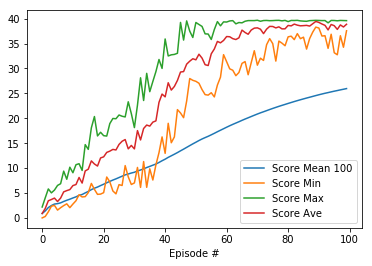

Episode 113(222sec)	 MIN:30.99 MAX:39.44 MEAN:36.49 MEANo100:30.26
Environment solved in 113 episodes!	Average Score: 30.26


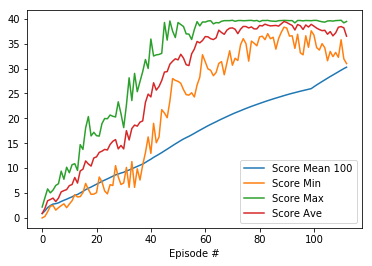

In [11]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 20        # learning timestep interval
LEARN_NUM = 10          # number of learning passes
EPSILON = 1.0           # explore->exploit noise process added to act step
EPSILON_DECAY = 1e-6    # decay rate for noise process

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
scores_plot, scores_min, scores_max, scores_ave = train()
# plot the scores
fig, ax = plt.subplots()

plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
plt.plot(np.arange(len(scores_min)), scores_min, label='Score Min')
plt.plot(np.arange(len(scores_max)), scores_max, label='Score Max')
plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
plt.xlabel('Episode #')

ax.legend()
plt.show()

### Smart agent

Please open the Smart_Agent.ipynb notebook to see how this agent works.

## 4. Future work

### Twin Delayed DDPG(TD3)

While DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function. Twin Delayed DDPG (TD3) is an algorithm which addresses this issue by introducing three critical tricks:

Trick One: Clipped Double-Q Learning. TD3 learns two Q-functions instead of one (hence “twin”), and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.

Trick Two: “Delayed” Policy Updates. TD3 updates the policy (and target networks) less frequently than the Q-function. The paper recommends one policy update for every two Q-function updates.

Trick Three: Target Policy Smoothing. TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.

Together, these three tricks result in substantially improved performance over baseline DDPG.


### Distributed Distributional Deterministic Policy Gradients(D4PG)

from https://openreview.net/forum?id=SyZipzbCb author mentioned:

This work adopts the very successful distributional perspective on reinforcement learning and adapts it to the continuous control setting. We combine this within a distributed framework for off-policy learning in order to develop what we call the Distributed Distributional Deep Deterministic Policy Gradient algorithm, D4PG. We also combine this technique with a number of additional, simple improvements such as the use of N-step returns and prioritized experience replay. Experimentally we examine the contribution of each of these individual components, and show how they interact, as well as their combined contributions. Our results show that across a wide variety of simple control tasks, difficult manipulation tasks, and a set of hard obstacle-based locomotion tasks the D4PG algorithm achieves state of the art performance.

<img src="./D4.png"  height="500" width="800" align='left'>




### Prioritized Replay

Prioritized replay can make learning from experience replay
more efficient. Here's one possible implementation of prioritized replay.

<img src="./priority.png"  height="500" width="800" align='left'>




## 5. Refernece
- Deterministic Policy Gradient Algorithms, Silver et al. 2014
- Continuous Control With Deep Reinforcement Learning, Lillicrap et al. 2016
- https://spinningup.openai.com/en/latest/algorithms/ddpg.html#background
- https://spinningup.openai.com/en/latest/algorithms/td3.html
- https://openreview.net/forum?id=SyZipzbCb